In [37]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)

minority_digit = 9
targets = train_ds.targets.numpy()

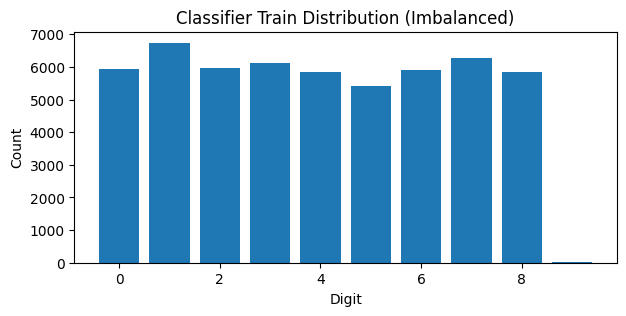

Need synthetic minority samples to balance: 6712


In [40]:
gan_minority_keep = 800

clf_minority_keep = 30

minor_all = np.where(targets == minority_digit)[0]
major_all = np.where(targets != minority_digit)[0]
np.random.shuffle(minor_all)

minor_gan_idx = minor_all[:gan_minority_keep]
gan_subset = Subset(train_ds, minor_gan_idx)

minor_clf_idx = minor_all[:clf_minority_keep]
imbalanced_idx = np.concatenate([major_all, minor_clf_idx])
np.random.shuffle(imbalanced_idx)
imbal_train = Subset(train_ds, imbalanced_idx)

counts = np.bincount(targets[imbalanced_idx], minlength=10)
plt.figure(figsize=(7,3))
plt.bar(range(10), counts)
plt.title("Classifier Train Distribution (Imbalanced)")
plt.xlabel("Digit"); plt.ylabel("Count")
plt.show()

gan_loader  = DataLoader(gan_subset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)

need = int(counts.max() - counts[minority_digit])
need = max(0, need)
print("Need synthetic minority samples to balance:", need)


In [42]:
def show_samples(imgs, title="samples", nrow=8):
    grid = make_grid(imgs, nrow=nrow, normalize=True)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(title)
    plt.show()

In [49]:
latent_dim = 100
img_dim = 28 * 28

class VGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class VDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x)

Gv = VGenerator().to(device)
Dv = VDiscriminator().to(device)

crit_v = nn.BCEWithLogitsLoss()
opt_Gv = optim.Adam(Gv.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_Dv = optim.Adam(Dv.parameters(), lr=1e-4, betas=(0.5, 0.999))

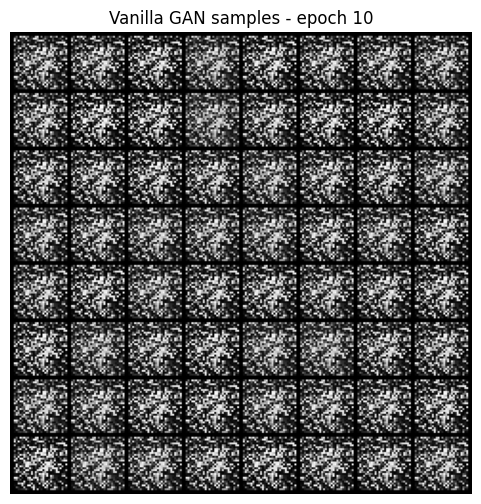

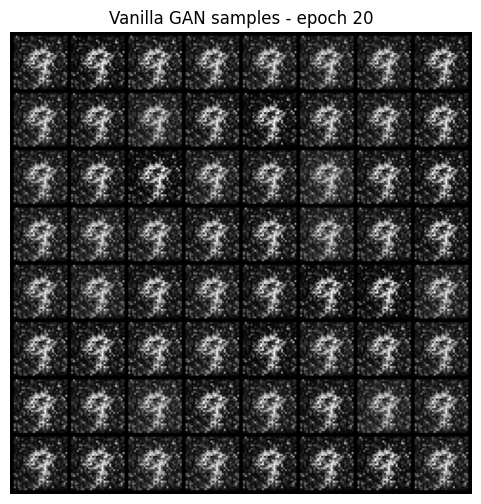

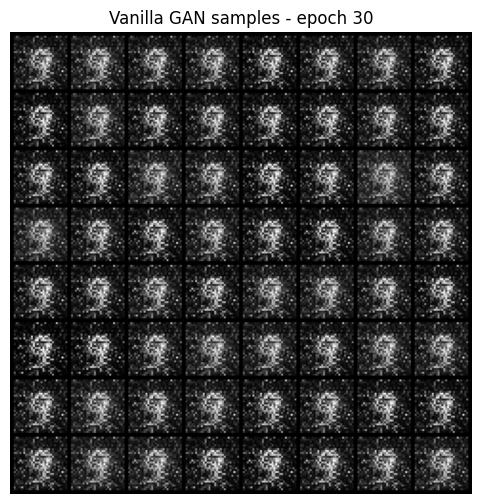

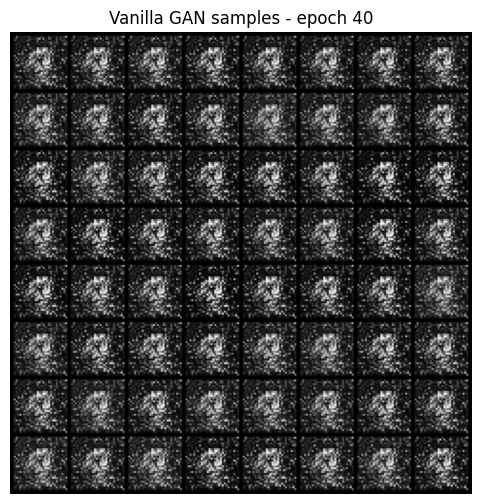

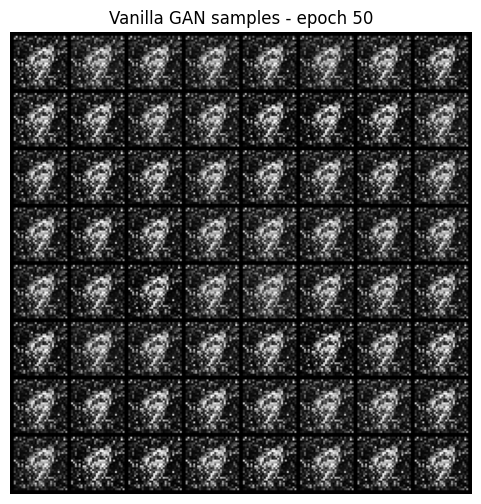

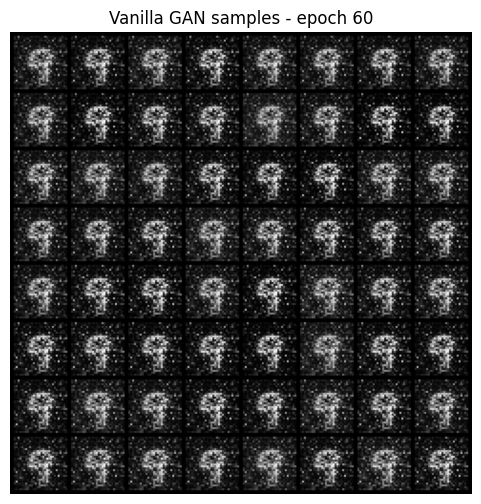

In [50]:
epochs_v = 60
sample_every = 10

for epoch in range(1, epochs_v + 1):
    Gv.train(); Dv.train()
    for real_imgs, _ in gan_loader:
        real_imgs = real_imgs.to(device).view(real_imgs.size(0), -1)
        bs = real_imgs.size(0)

        real_y = torch.full((bs,1), 0.9, device=device)
        fake_y = torch.zeros(bs,1, device=device)

        # ---- Train D ----
        z = torch.randn(bs, latent_dim, device=device)
        fake_imgs = Gv(z).detach()

        loss_D = crit_v(Dv(real_imgs), real_y) + crit_v(Dv(fake_imgs), fake_y)

        opt_Dv.zero_grad()
        loss_D.backward()
        nn.utils.clip_grad_norm_(Dv.parameters(), 1.0)
        opt_Dv.step()

        # ---- Train G ----
        z = torch.randn(bs, latent_dim, device=device)
        gen_imgs = Gv(z)
        loss_G = crit_v(Dv(gen_imgs), real_y)

        opt_Gv.zero_grad()
        loss_G.backward()
        nn.utils.clip_grad_norm_(Gv.parameters(), 1.0)
        opt_Gv.step()

    if epoch % sample_every == 0:
        with torch.no_grad():
            samp = Gv(torch.randn(64, latent_dim, device=device)).view(-1,1,28,28).cpu()
        show_samples(samp, title=f"Vanilla GAN samples - epoch {epoch}")

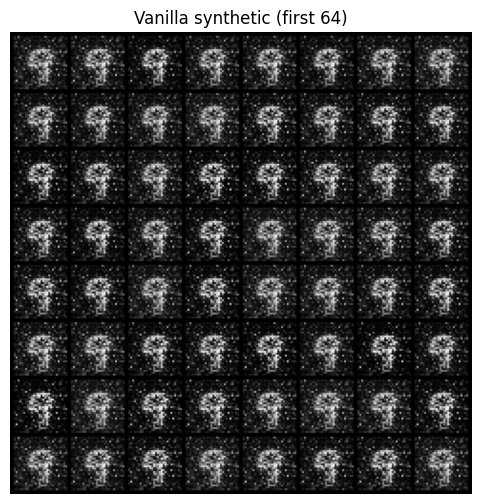

In [51]:
with torch.no_grad():
    z = torch.randn(need, latent_dim, device=device)
    syn_v = Gv(z).view(-1,1,28,28).cpu()

syn_labels = torch.full((need,), minority_digit, dtype=torch.long)

show_samples(syn_v[:64], title="Vanilla synthetic (first 64)")

In [56]:
class DCGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )
    def forward(self, x):
        return self.net(x)

Gd = DCGenerator().to(device)
Dd = DCDiscriminator().to(device)

crit_d = nn.BCEWithLogitsLoss()
opt_Gd = optim.Adam(Gd.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_Dd = optim.Adam(Dd.parameters(), lr=1e-4, betas=(0.5, 0.999))

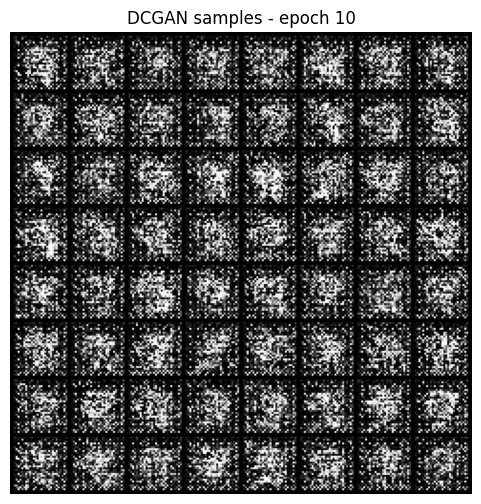

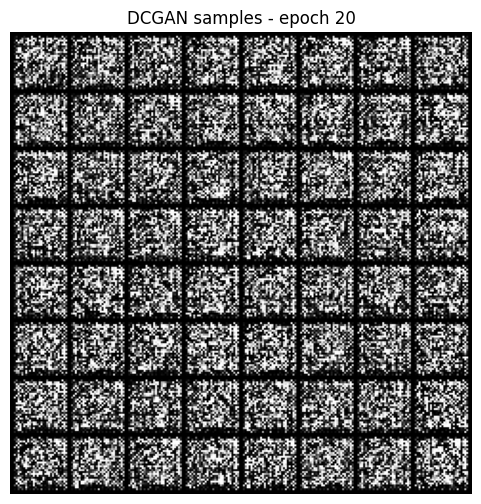

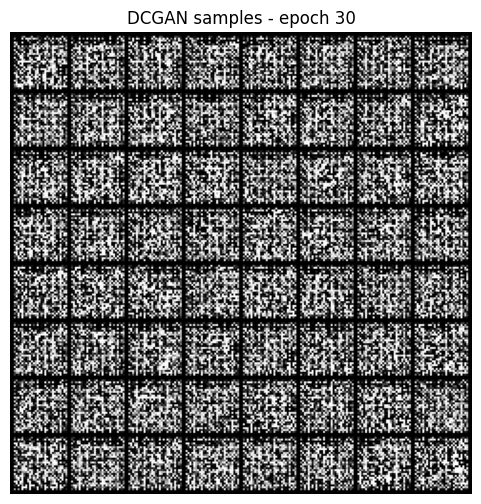

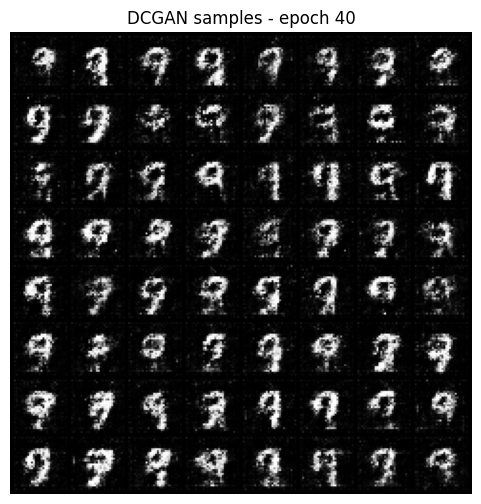

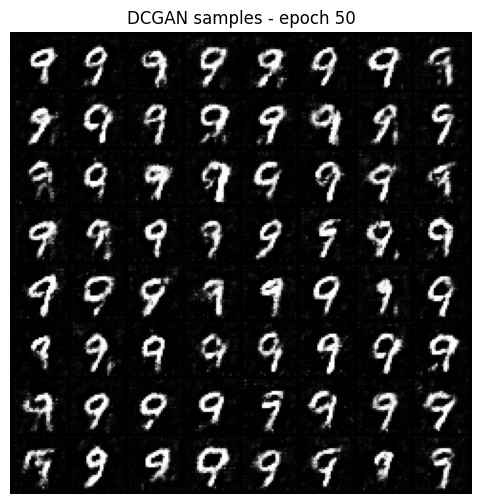

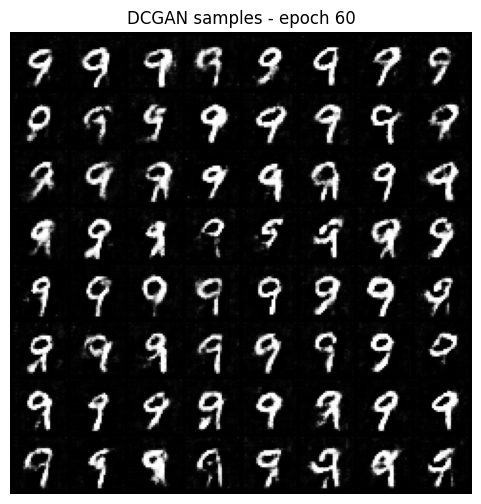

In [57]:
epochs_d = 60
sample_every = 10

for epoch in range(1, epochs_d + 1):
    Gd.train(); Dd.train()
    for real_imgs, _ in gan_loader:
        real_imgs = real_imgs.to(device)
        bs = real_imgs.size(0)

        real_y = torch.full((bs,1), 0.9, device=device)
        fake_y = torch.zeros(bs,1, device=device)

        # ---- Train D ----
        z = torch.randn(bs, latent_dim, 1, 1, device=device)
        fake_imgs = Gd(z).detach()

        loss_D = crit_d(Dd(real_imgs), real_y) + crit_d(Dd(fake_imgs), fake_y)

        opt_Dd.zero_grad()
        loss_D.backward()
        nn.utils.clip_grad_norm_(Dd.parameters(), 1.0)
        opt_Dd.step()

        # ---- Train G ----
        z = torch.randn(bs, latent_dim, 1, 1, device=device)
        gen_imgs = Gd(z)
        loss_G = crit_d(Dd(gen_imgs), real_y)

        opt_Gd.zero_grad()
        loss_G.backward()
        nn.utils.clip_grad_norm_(Gd.parameters(), 1.0)
        opt_Gd.step()

    if epoch % sample_every == 0:
        with torch.no_grad():
            samp = Gd(torch.randn(64, latent_dim, 1, 1, device=device)).cpu()
        show_samples(samp, title=f"DCGAN samples - epoch {epoch}")

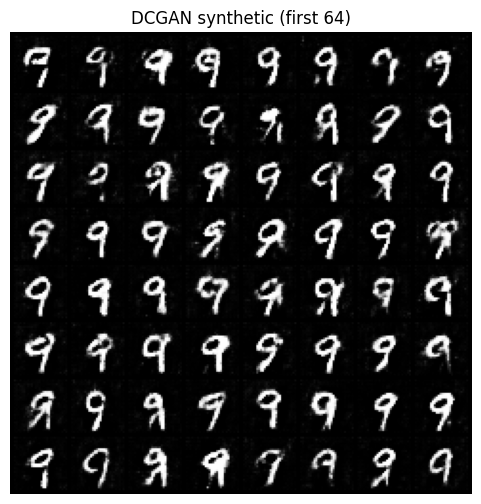

In [58]:
with torch.no_grad():
    z = torch.randn(need, latent_dim, 1, 1, device=device)
    syn_d = Gd(z).cpu()

show_samples(syn_d[:64], title="DCGAN synthetic (first 64)")

In [59]:
def subset_to_tensor(subset):
    xs, ys = [], []
    for x, y in DataLoader(subset, batch_size=512, shuffle=False):
        xs.append(x); ys.append(y)
    return torch.cat(xs, 0), torch.cat(ys, 0)

X_imbal, y_imbal = subset_to_tensor(imbal_train)

X_vbal = torch.cat([X_imbal, syn_v], dim=0)
y_vbal = torch.cat([y_imbal, syn_labels], dim=0)

X_dbal = torch.cat([X_imbal, syn_d], dim=0)
y_dbal = torch.cat([y_imbal, syn_labels], dim=0)

train_loader_imbal = DataLoader(TensorDataset(X_imbal, y_imbal), batch_size=128, shuffle=True, num_workers=2)
train_loader_vbal  = DataLoader(TensorDataset(X_vbal,  y_vbal),  batch_size=128, shuffle=True, num_workers=2)
train_loader_dbal  = DataLoader(TensorDataset(X_dbal,  y_dbal),  batch_size=128, shuffle=True, num_workers=2)

In [60]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

In [61]:
def train_classifier(loader, epochs=5):
    model = CNN().to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            loss = loss_fn(model(x), y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item()
        print(f"Epoch {ep}/{epochs} - loss={total/len(loader):.4f}")

    return model

def evaluate(model, title=""):
    model.eval()
    all_y, all_p = [], []

    with torch.no_grad():
        for x, y in test_loader:
            pred = torch.argmax(model(x.to(device)), dim=1).cpu().numpy()
            all_p.append(pred)
            all_y.append(y.numpy())

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)

    acc = accuracy_score(y_true, y_pred)

    y_true_m = (y_true == minority_digit).astype(int)
    y_pred_m = (y_pred == minority_digit).astype(int)

    prec = precision_score(y_true_m, y_pred_m, zero_division=0)
    rec  = recall_score(y_true_m, y_pred_m, zero_division=0)
    f1   = f1_score(y_true_m, y_pred_m, zero_division=0)

    print(f"\n=== {title} ===")
    print("Accuracy:", acc)
    print("Minority Precision/Recall/F1:", prec, rec, f1)
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nReport:\n", classification_report(y_true, y_pred, digits=4))

    return acc, prec, rec, f1

In [63]:
print("Training classifier on Imbalanced...")
m1 = train_classifier(train_loader_imbal, epochs=1)
acc1, p1, r1, f1_1 = evaluate(m1, title="Scenario 1: Imbalanced")

print("\nTraining classifier on Vanilla-balanced...")
m2 = train_classifier(train_loader_vbal, epochs=1)
acc2, p2, r2, f1_2 = evaluate(m2, title="Scenario 2: Balanced with Vanilla GAN")

print("\nTraining classifier on DCGAN-balanced (Advanced Variant)...")
m3 = train_classifier(train_loader_dbal, epochs=1)
acc3, p3, r3, f1_3 = evaluate(m3, title="Scenario 3: Balanced with DCGAN (Advanced)")

print("\n===== SUMMARY (Minority digit=9) =====")
print("Imbalanced     -> Acc:", acc1, "| Prec:", p1, "| Rec:", r1, "| F1:", f1_1)
print("Vanilla (Bal)  -> Acc:", acc2, "| Prec:", p2, "| Rec:", r2, "| F1:", f1_2)
print("DCGAN (Bal)    -> Acc:", acc3, "| Prec:", p3, "| Rec:", r3, "| F1:", f1_3)

Training classifier on Imbalanced...
Epoch 1/1 - loss=0.1955

=== Scenario 1: Imbalanced ===
Accuracy: 0.8871
Minority Precision/Recall/F1: 1.0 0.023785926660059464 0.046466602129719266

Confusion Matrix:
 [[ 963    0    0    0    0    2    6    5    4    0]
 [   0 1120    3    2    2    1    3    0    4    0]
 [   1    2 1003    4    3    0    0   16    3    0]
 [   0    0    1  994    0    3    0   10    2    0]
 [   0    0    0    0  976    0    2    2    2    0]
 [   1    0    1    2    0  882    2    3    1    0]
 [   2    2    0    0    3    4  946    0    1    0]
 [   0    2    9    1    0    0    0 1014    2    0]
 [   3    0    3    4    4    0    2    9  949    0]
 [   7    3    2   24  380   37    0  503   29   24]]

Report:
               precision    recall  f1-score   support

           0     0.9857    0.9827    0.9842       980
           1     0.9920    0.9868    0.9894      1135
           2     0.9814    0.9719    0.9766      1032
           3     0.9641    0.9842   